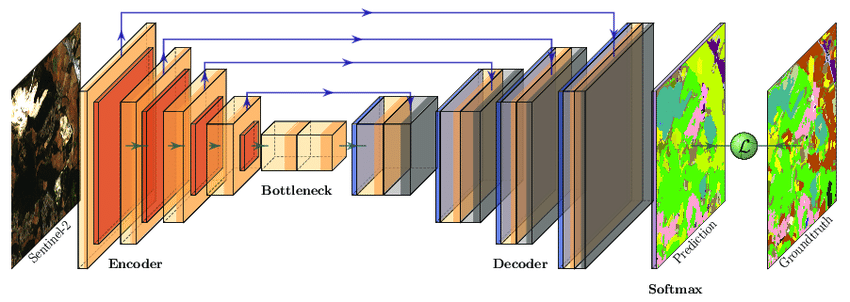

Unet is first designed in 2015 as an evolution form of the traditional convolutional NN. Its input would be an image, and the output would be a label. In medical cases, it further requires the ability to localize the area of abnormality. These two abilities (distinguish borders and localize) can be achieved by Unet after doing classification of every pixel. 

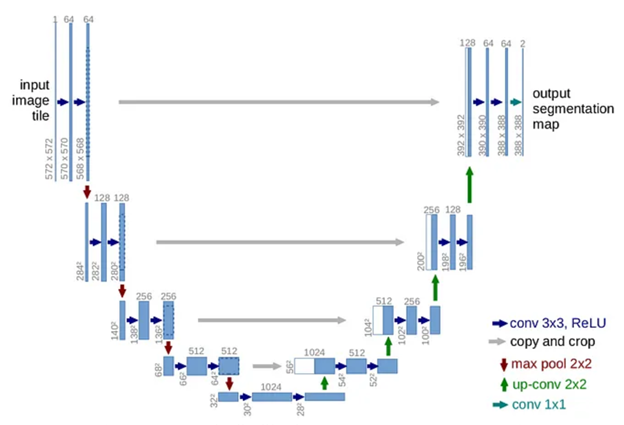

There are many names for the left path (encoder, analysis, contracting…) and right path (decoder, synthesis, expansive…). In general, the left path is the basic convolutional process (CNN, max pooling) called down sampling and right path is transposed 2d convolutional layers called up sampling. 

Further detailed look is here.

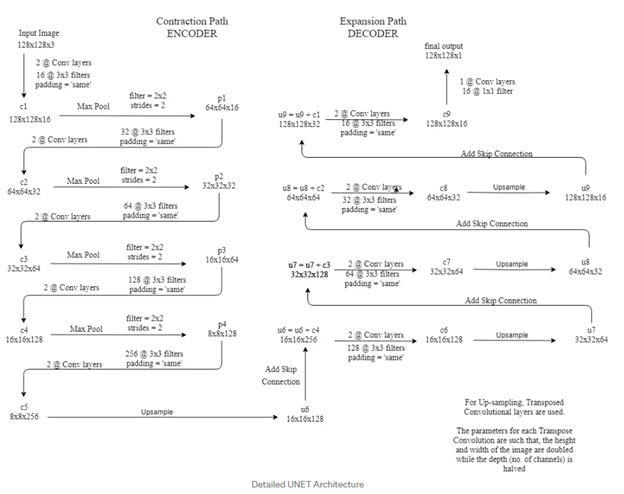

Codes that would demonstrate how this architecture is built using python is listed below.

In [ ]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

Now that we have the whole picture, we are going to step-by-step analyze each of these building block. 

First layer in the left path uses two convolutional layers, a max pooling operation and a dropout feature (optional).
conv_layer1 -> conv_layer2 -> max_pooling -> dropout(optional)

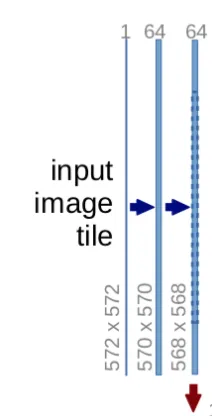

Notice that each process constitutes two convolutional layers, and the number of channel changes from 1 → 64, as convolution process will increase the depth of the image. The red arrow pointing down is the max pooling process which halves down size of image(the size reduced from 572x572 → 568x568 is due to padding issues, but the implementation here uses padding= “same”).

As such, this code is written as:


In [ ]:
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)
pool1 = Dropout(0.25)(pool1)

Now we are going to analyze and explain each part of this process. 

First is the convolutional layer. There are two of them.
They work in mechanism displayed in these pictures:

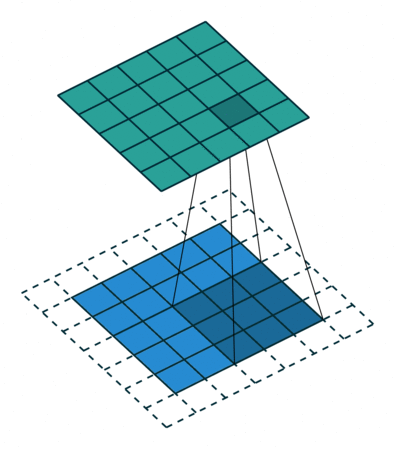

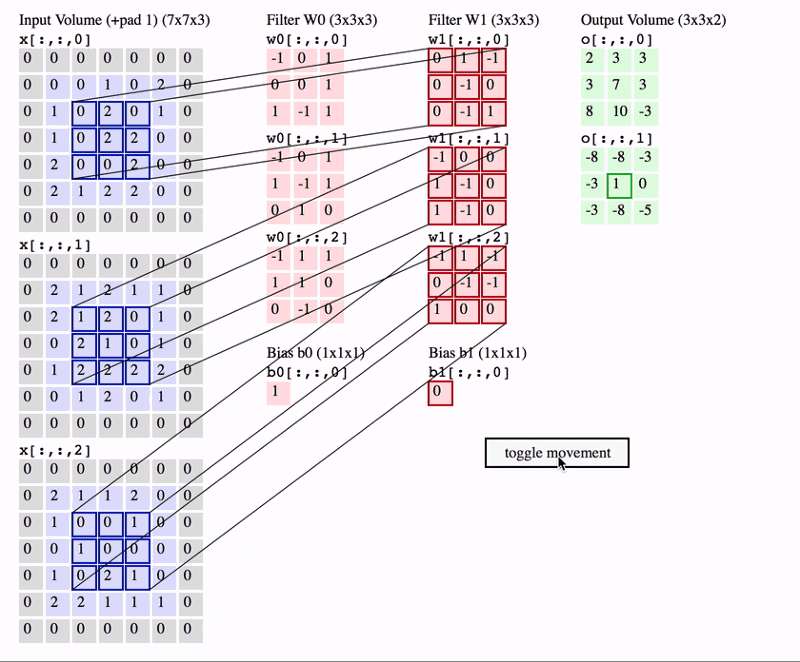

Various parameters that we also need to know include:
Kernel Size: The kernel size defines the field of view of the convolution. A common choice for 2D is 3 — that is 3x3 pixels. Note that we also use this kernel size in our code building blocks.

Stride: The stride defines the step size of the kernel when traversing the image. While its default is usually 1, we can use a stride of 2 for downsampling an image similar to MaxPooling.

Padding: The padding defines how the border of a sample is handled. A (half) padded convolution will keep the spatial output dimensions equal to the input, whereas unpadded convolutions will crop away some of the borders if the kernel is larger than 1.

Input & Output Channels: A convolutional layer takes a certain number of input channels (I) and calculates a specific number of output channels (O). The needed parameters for such a layer can be calculated by I*O*K, where K equals the number of values in the kernel.

Second is the max pooling operation. This operation is to reduce the size of the feature map so that we have fewer parameters in the network.

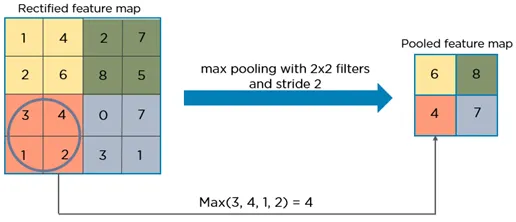

Simply put, for every 2x2 block, we output only 1 block with the highest value selected. This is to preserve only the most important feature while removing the irrelevant ones. 

Various parameters for this operation are:

Kernel size:The kernel size refers to the spatial extent of the pooling operation. It is typically represented as a square matrix with a certain width and height. The most common pool size used in practice is 2x2, but other sizes can also be used. During the pooling operation, the input feature map is divided into non-overlapping regions (sub-regions) of the defined pool size.

Stride:The stride determines the step size or the amount of shift between the successive pool windows. It specifies how much the pooling window is moved horizontally and vertically after each pooling operation. For example, a stride of 2 means that the pooling window moves two units at a time, effectively skipping one row and one column in each step. A stride of 1 means that the pooling window moves one unit at a time, with no skipping.

Special mention here is that both convolutional operation and max pooling operation are to reduce the size of the image. As such, both of them are down sampling techniques. 

Finally, dropout a an optional function that can introduced in this layer to prevent overfitting. 
It was initially believed to be less effective in convolutional layers, which are commonly used in image processing tasks. While the shared-filter architecture helps to some extent, dropout can still provide additional regularization and enhance the network's generalization capabilities. It introduces randomness by temporarily 'dropping out' (ignoring) some of the neurons during training, forcing the network to learn more robust and generalized representations.
This technique is demonstrated below. 

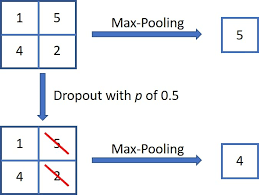

Now that we understand all these techniques that are used within this layer, let's get back on track with our building block, if you glance back at the architecture layout, you will see that the first layer mentioned above is repeated three more times. 

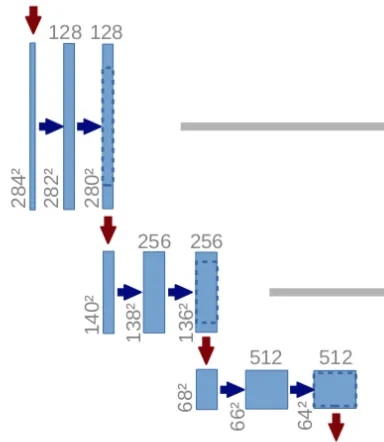

As such, its code are:

In [ ]:
conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
pool2 = Dropout(0.5)(pool2)

conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)
pool3 = Dropout(0.5)(pool3)

conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)
pool4 = Dropout(0.5)(pool4)

Finally, we reach the bottom most part displayed in the architecture that connect the left and right path. This is called 'bottleneck' or 'bridge' layer. 

The bottleneck layer serves as a shortcut connection, allowing the information from the contracting path to directly flow to the expanding path. This helps in the transfer of essential spatial information and assists in better reconstruction of the output.

By omitting the max pooling operation in the bottleneck layer, the U-Net architecture retains more spatial information, which can be beneficial for tasks that require precise localization or segmentation, such as in medical image analysis or semantic segmentation.

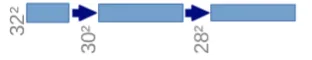

This part include two convolutional layers without max pooling.The image at this moment has been resized to 28x28x1024.

In [ ]:
# Bridge or bottleneck layer
convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

Now we move on to the right path. This path would make the processed image upscaled back to its orginal size. The first layer include:

conv_2d_transpose -> concatenate -> conv_layer1 -> conv_layer2

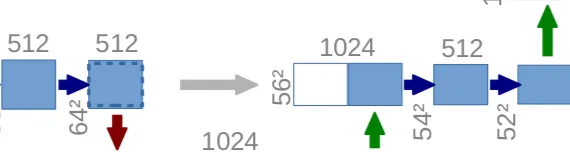

The image is upsized from 28x28x1024 → 56x56x512, and then, this image is concatenated with the corresponding image from the contracting path and together makes an image of size 56x56x1024. Two more convolutional layers are added following this step.

Each layer is explained in the following:

Conv2D Transpose:
The "conv_2d_transpose" layer is a type of upsampling layer that performs the inverse operation of a convolutional layer. It increases the spatial dimensions of the input feature map while reducing the number of channels. Convolutional transpose layers achieve upsampling by using learnable parameters (transpose kernels) to fill in the gaps between the input pixels. These layers help restore the spatial resolution that was reduced during the contracting path.

Concatenate:
The "concatenate" layer is used to combine feature maps from the corresponding contracting path (encoder) layers. It concatenates or merges the feature maps from the upsampling layer and the corresponding contracting path layer. This step ensures that the high-resolution features from the contracting path are appropriately aligned with the upsampled features. The concatenation operation typically occurs along the channel axis.

Convolutional Layer 1:
The "conv_layer1" represents a standard convolutional layer in the decoder. It applies a set of learnable filters to the concatenated feature maps obtained from the previous step. These filters perform spatial convolutions across the feature maps to capture and extract relevant patterns and features. The output of this layer provides a refined representation of the merged features.

Convolutional Layer 2:
The "conv_layer2" is another convolutional layer in the decoder. It further refines the feature representation obtained from the previous convolutional layer. The purpose of this layer is to extract more abstract and complex features from the concatenated and refined feature maps. The number of filters and the size of the convolutional kernels used in this layer can vary based on the specific U-Net implementation and the requirements of the task.

Together, these layers in the right path of the U-Net architecture, specifically the conv_2d_transpose, concatenate, conv_layer1, and conv_layer2, contribute to the process of upsampling, merging feature maps, and refining the features to reconstruct the desired output.

This whole process is repeated three more times. 

Codes for these four layers are:


In [ ]:
deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
uconv4 = concatenate([deconv4, conv4])
uconv4 = Dropout(0.5)(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
uconv3 = concatenate([deconv3, conv3])
uconv3 = Dropout(0.5)(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
uconv2 = concatenate([deconv2, conv2])
uconv2 = Dropout(0.5)(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
uconv1 = concatenate([deconv1, conv1])
uconv1 = Dropout(0.5)(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

Now we’ve reached the uppermost of the architecture, the last step is to reshape the image to satisfy our prediction requirements.

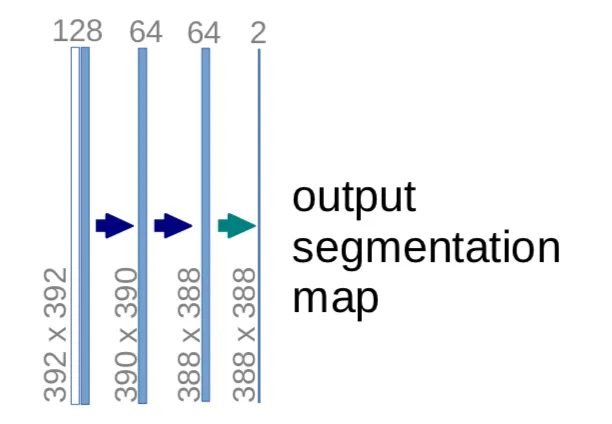

In [ ]:
output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

The last layer is a convolution layer with 1 filter of size 1x1(notice that there is no dense layer in the whole network). And the rest left is the same for neural network training.